In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import os
import yaml

from utils.model.models import Classifier
from utils.config import config as cfg

In [70]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

default_dirs = cfg.get_default_dirs()

Current device: cuda:0


In [71]:
# Custom dataset with our model parameters
class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 90):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        self.angle_change = angle_change

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        weights = torch.tensor(self.dataset.iloc[idx, :-1].values, dtype=torch.float32)
        angle = torch.tensor(self.dataset.iloc[idx, -1]/self.angle_change, dtype=torch.int64)

        return weights, angle

In [72]:
dataset_path = os.path.join(default_dirs["DATASETS_DIR"], "two_angles.csv")

# Create a dataset
dataset = ModelParamsDataset(dataset_path)

torch.manual_seed(42)

# Split into train, validation and test sets
dataset_train, dataset_valid, dataset_test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test)

print("Train sample:", len(dataset_train))
print("Validation sample:", len(dataset_valid))
print("Test sample:", len(dataset_test))

Train sample: 3200
Validation sample: 400
Test sample: 400


In [73]:
# Load training config

config_name = "train_angle_classifier.yaml"
config = cfg.load_config(config_name)

  0%|          | 0/10 [00:00<?, ?it/s]

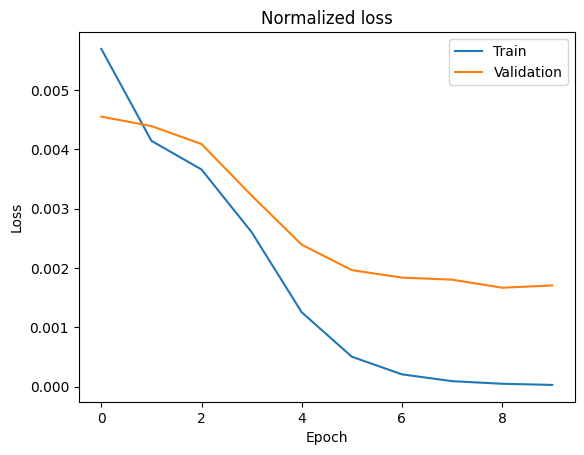

In [74]:
# TRAINING

# Hyperparameters
hyperparameters = config["HYPERPARAMETERS"]
epochs = hyperparameters["EPOCHS"]
learning_rate = hyperparameters["LEARNING_RATE"]
seed = hyperparameters["SEED"]

model_config = config["MODEL"]
input_dim = model_config["INPUT_DIM"]
hidden_dims = model_config["HIDDEN_DIMS"]
output_dim = model_config["OUTPUT_DIM"]

torch.manual_seed(seed)

model = Classifier(input_dim, hidden_dims, output_dim)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Logging
total_losses_train = []
total_losses_validation = []

# Training
for epoch in tqdm(range(epochs)):
    total_loss = 0
    model.train()
    for X, y in dataloader_train:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_losses_train.append(total_loss)

    total_loss = 0
    model.eval()
    for X, y in dataloader_valid:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X.float())
        y = torch.nn.functional.one_hot(y, num_classes=output_dim).float()
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    total_losses_validation.append(total_loss)


# Plot the losses
total_losses_train = np.array(total_losses_train)/len(dataset_train)
total_losses_validation = np.array(total_losses_validation)/len(dataset_valid)

plt.plot(total_losses_train, label="Train")
plt.plot(total_losses_validation, label="Validation")
plt.legend()
plt.title("Normalized loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

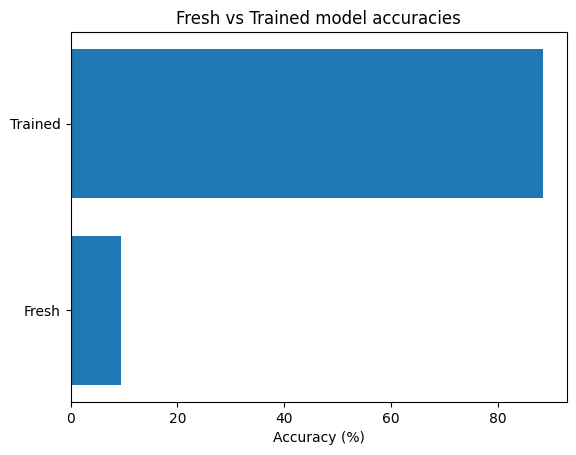

In [75]:
model_fresh = Classifier(input_dim, hidden_dims, output_dim)
model_fresh.to(device)

total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model_fresh(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_fresh = total_correct / len(dataset_test) * 100
total_correct = 0
for X, y in dataloader_test:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X.float())
    # Accuracy
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y).sum()
    total_correct += correct

accuracy_trained = total_correct / len(dataset_test) * 100

plt.title("Fresh vs Trained model accuracies")
plt.barh(["Fresh", "Trained"], [accuracy_fresh.cpu().detach().numpy(), accuracy_trained.cpu().detach().numpy()])
plt.xlabel("Accuracy (%)")
plt.show()